# Introduction & Overview

## The stock market
This notebook provides an analysis and approach to stock-market activities. Every day the market is open, the question to the would-be trader presents:
- Buy
- Sell
- Hold

This notebook explores several approaches to answering this *daily* question.

Modern algorithmic trading asks not daily, but [many times per second](https://en.wikipedia.org/wiki/High-frequency_trading), whether to buy, sell, or hold. Being a lay practitioner without access to industrial trading tools, I approach this as a per-day question.

## The CRISP-DM Framework

The process is described according to the [CRISP-DM framework](https://www.datascience-pm.com/crisp-dm-2/), a standardized process for a data-mining project such as this one. All quotes that follow,
> which are indicated like this

are from the paper titled *CRISP-DM: Towards a Standard Process Model for Data Mining* by Wirth & Hipp, in the document "crisp-dm-overview.pdf" as downloaded [from this source](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip), and copied [locally here](./docs/crisp-dm-overview.pdf).

# Imports

In [31]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update(
    {
        "axes.grid": True,
        "figure.figsize": (16, 4),
    },
)

# Business Understanding

> This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary project plan designed to achieve the objectives.

The project objectives are to make stock trading recommendations on a daily basis, for a trading client. The project has been specified to concentrate only on equities trading, as opposed to any of the more complex financial instruments, such as options, shorts, bonds, etc...

The preliminary project plan is to obtain representative data from various publicly traded stocks, and then to choose a trading strategy, and to develop an algorithm to implement this strategy. Having obtained this data, multiple models will be developed, and compared to a benchmark of performance, here the S&P 500.

# Data Understanding

> The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.

Data sets have been obtained for approximately 500 stocks comprising the S&P 500 index, at 1 day increments for a period of approximately 90 days. For comparison purposes, I also obtained a daily closing price for the S&P 500, a common benchmark for trading performance.

Load the data set

In [3]:
df = pd.read_csv("./data/50_stocks.csv")[::-1]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df

,TSLA,JNJ,BMY,LDOS,DOV,CVX,KKR,DGX,STZ,BX,HBAN,A,FDX,MMC,CPB,PM,PWR,XYL,AWK,MGM,RCL,WY,WMB,HAL,HAS,BRO,UNH,VTRS,RVTY,CRL,NTAP,LOW,GL,VICI,EOG,ABT,NDAQ,K,BKNG,IT,BBY,NCLH,CBRE,WFC,EXC,AMGN,MMM,ABNB,MCD,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-08,172.98,151.59,51.10,129.24,176.08,161.27,101.65,130.04,266.00,129.32,14.01,144.46,275.57,204.28,43.72,90.32,262.26,127.75,120.02,46.30,138.29,34.42,38.95,40.96,57.59,85.51,456.00,11.75,106.41,254.92,105.82,242.59,107.85,29.63,135.45,110.52,62.14,57.48,3601.17,471.87,80.14,19.39,96.51,57.79,37.78,269.20,91.93,160.27,267.56,185.19
2024-04-09,176.88,152.29,51.60,127.10,177.35,162.00,100.27,132.75,262.97,132.00,14.04,147.40,276.37,204.33,44.45,91.07,256.40,128.93,121.85,46.41,133.18,35.03,39.24,40.98,57.33,84.56,459.72,11.82,110.72,257.15,104.15,244.39,107.61,29.80,137.06,112.44,63.56,57.12,3581.48,469.89,82.55,19.41,96.20,57.58,37.87,270.36,92.61,162.66,269.44,185.67
2024-04-10,171.76,150.20,50.29,126.22,173.83,162.67,99.01,131.62,264.92,126.08,13.58,144.16,270.30,201.18,43.68,89.72,254.30,128.19,118.31,44.68,130.90,33.60,38.88,41.11,56.78,83.60,450.05,11.71,107.90,247.49,102.60,237.16,104.93,28.11,137.95,111.17,63.01,57.01,3586.13,463.78,79.89,18.40,91.33,56.94,36.91,266.45,92.63,160.28,268.67,185.95
2024-04-11,174.60,148.79,49.12,126.64,173.28,161.89,100.45,130.02,268.34,126.87,13.49,145.00,272.18,199.19,43.21,89.43,258.00,128.79,117.82,44.72,133.75,33.65,38.60,40.94,56.23,82.65,441.72,11.57,108.50,246.42,104.86,235.44,49.17,28.20,137.27,111.45,63.06,56.17,3637.87,474.72,80.01,18.63,90.68,56.69,36.80,270.00,93.18,165.42,268.62,189.05
2024-04-12,171.05,147.52,48.28,125.73,172.06,158.96,97.29,128.53,262.24,123.47,13.31,140.73,267.80,198.07,42.31,88.85,254.69,128.11,116.57,42.48,127.67,33.24,38.08,39.67,55.80,81.90,439.20,11.33,103.49,241.34,101.81,232.05,59.09,27.94,135.29,109.11,61.52,55.42,3531.80,465.45,78.00,17.77,89.39,56.47,36.48,267.28,91.31,159.37,267.39,186.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,197.88,146.16,41.53,145.88,180.45,156.42,105.24,136.88,257.28,123.80,13.18,129.63,299.84,210.72,45.19,101.33,254.09,135.63,129.16,44.44,159.43,28.39,42.50,33.78,58.50,89.41,509.26,10.63,104.86,206.58,128.80,220.46,82.28,28.64,125.87,103.91,60.26,57.68,3961.50,449.06,84.29,18.79,89.11,59.39,34.61,312.45,102.19,151.63,254.84,193.25
2024-07-01,209.86,146.44,41.30,145.56,176.99,156.52,104.51,137.09,256.29,122.23,13.16,127.40,298.68,210.25,45.27,101.25,247.61,131.53,127.76,42.86,156.47,27.56,42.39,33.43,57.52,89.11,494.65,10.59,103.00,203.24,130.24,213.56,82.83,27.90,126.54,103.20,59.48,56.72,3884.88,441.32,82.29,17.68,85.97,60.59,34.55,311.01,100.61,151.63,249.99,197.20
2024-07-02,231.26,146.03,40.45,145.86,176.96,156.75,105.93,136.64,258.94,123.21,13.21,125.78,298.22,211.99,45.53,101.64,247.78,132.27,128.46,42.33,156.61,27.48,42.30,33.62,57.06,89.65,498.24,10.43,102.01,201.48,129.88,213.70,83.08,27.77,126.65,103.20,59.96,56.70,3916.21,446.12,82.17,17.61,87.08,60.97,34.53,310.77,101.62,154.34,247.79,200.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2024-04-08 to 2024-07-05
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    62 non-null     float64
 1   JNJ     62 non-null     float64
 2   BMY     62 non-null     float64
 3   LDOS    62 non-null     float64
 4   DOV     62 non-null     float64
 5   CVX     62 non-null     float64
 6   KKR     62 non-null     float64
 7   DGX     62 non-null     float64
 8   STZ     62 non-null     float64
 9   BX      62 non-null     float64
 10  HBAN    62 non-null     float64
 11  A       62 non-null     float64
 12  FDX     62 non-null     float64
 13  MMC     62 non-null     float64
 14  CPB     62 non-null     float64
 15  PM      62 non-null     float64
 16  PWR     62 non-null     float64
 17  XYL     62 non-null     float64
 18  AWK     62 non-null     float64
 19  MGM     62 non-null     float64
 20  RCL     62 non-null     float64
 21  WY      62 non-null  

Load the S&P 500 index data, and perform similar basic cleanups on date and column renaming
- This data set was not from yahoo finance, but it turns out to have the identical format

In [5]:
def read_stock_csv(stock: str) -> pd.DataFrame:
    """
    Loads the stock-price data from a csv file obtained from yahoo finance
    Retains only the date, which is set as the index, and the closing price
    """
    filename = f"./data/{stock}.csv"
    df = pd.read_csv(filename)[["Date", "Close"]]
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df.rename(columns={"Close": stock}, inplace=True)
    return df

In [6]:
df_sp500 = read_stock_csv(stock="SPX")
df_sp500

,SPX
Date,
2024-07-05,"5,567.19"
2024-07-03,"5,537.02"
2024-07-02,"5,509.01"
2024-07-01,"5,475.09"
2024-06-28,"5,460.48"
...,...
2024-04-12,"5,123.41"
2024-04-11,"5,199.06"
2024-04-10,"5,160.64"


In [7]:
df["SPX"] = df_sp500["SPX"].str.replace(",", "").apply(float)
df

,TSLA,JNJ,BMY,LDOS,DOV,CVX,KKR,DGX,STZ,BX,HBAN,A,FDX,MMC,CPB,PM,PWR,XYL,AWK,MGM,RCL,WY,WMB,HAL,HAS,BRO,UNH,VTRS,RVTY,CRL,NTAP,LOW,GL,VICI,EOG,ABT,NDAQ,K,BKNG,IT,BBY,NCLH,CBRE,WFC,EXC,AMGN,MMM,ABNB,MCD,AMZN,SPX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-08,172.98,151.59,51.10,129.24,176.08,161.27,101.65,130.04,266.00,129.32,14.01,144.46,275.57,204.28,43.72,90.32,262.26,127.75,120.02,46.30,138.29,34.42,38.95,40.96,57.59,85.51,456.00,11.75,106.41,254.92,105.82,242.59,107.85,29.63,135.45,110.52,62.14,57.48,3601.17,471.87,80.14,19.39,96.51,57.79,37.78,269.20,91.93,160.27,267.56,185.19,5202.39
2024-04-09,176.88,152.29,51.60,127.10,177.35,162.00,100.27,132.75,262.97,132.00,14.04,147.40,276.37,204.33,44.45,91.07,256.40,128.93,121.85,46.41,133.18,35.03,39.24,40.98,57.33,84.56,459.72,11.82,110.72,257.15,104.15,244.39,107.61,29.80,137.06,112.44,63.56,57.12,3581.48,469.89,82.55,19.41,96.20,57.58,37.87,270.36,92.61,162.66,269.44,185.67,5209.91
2024-04-10,171.76,150.20,50.29,126.22,173.83,162.67,99.01,131.62,264.92,126.08,13.58,144.16,270.30,201.18,43.68,89.72,254.30,128.19,118.31,44.68,130.90,33.60,38.88,41.11,56.78,83.60,450.05,11.71,107.90,247.49,102.60,237.16,104.93,28.11,137.95,111.17,63.01,57.01,3586.13,463.78,79.89,18.40,91.33,56.94,36.91,266.45,92.63,160.28,268.67,185.95,5160.64
2024-04-11,174.60,148.79,49.12,126.64,173.28,161.89,100.45,130.02,268.34,126.87,13.49,145.00,272.18,199.19,43.21,89.43,258.00,128.79,117.82,44.72,133.75,33.65,38.60,40.94,56.23,82.65,441.72,11.57,108.50,246.42,104.86,235.44,49.17,28.20,137.27,111.45,63.06,56.17,3637.87,474.72,80.01,18.63,90.68,56.69,36.80,270.00,93.18,165.42,268.62,189.05,5199.06
2024-04-12,171.05,147.52,48.28,125.73,172.06,158.96,97.29,128.53,262.24,123.47,13.31,140.73,267.80,198.07,42.31,88.85,254.69,128.11,116.57,42.48,127.67,33.24,38.08,39.67,55.80,81.90,439.20,11.33,103.49,241.34,101.81,232.05,59.09,27.94,135.29,109.11,61.52,55.42,3531.80,465.45,78.00,17.77,89.39,56.47,36.48,267.28,91.31,159.37,267.39,186.13,5123.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,197.88,146.16,41.53,145.88,180.45,156.42,105.24,136.88,257.28,123.80,13.18,129.63,299.84,210.72,45.19,101.33,254.09,135.63,129.16,44.44,159.43,28.39,42.50,33.78,58.50,89.41,509.26,10.63,104.86,206.58,128.80,220.46,82.28,28.64,125.87,103.91,60.26,57.68,3961.50,449.06,84.29,18.79,89.11,59.39,34.61,312.45,102.19,151.63,254.84,193.25,5460.48
2024-07-01,209.86,146.44,41.30,145.56,176.99,156.52,104.51,137.09,256.29,122.23,13.16,127.40,298.68,210.25,45.27,101.25,247.61,131.53,127.76,42.86,156.47,27.56,42.39,33.43,57.52,89.11,494.65,10.59,103.00,203.24,130.24,213.56,82.83,27.90,126.54,103.20,59.48,56.72,3884.88,441.32,82.29,17.68,85.97,60.59,34.55,311.01,100.61,151.63,249.99,197.20,5475.09
2024-07-02,231.26,146.03,40.45,145.86,176.96,156.75,105.93,136.64,258.94,123.21,13.21,125.78,298.22,211.99,45.53,101.64,247.78,132.27,128.46,42.33,156.61,27.48,42.30,33.62,57.06,89.65,498.24,10.43,102.01,201.48,129.88,213.70,83.08,27.77,126.65,103.20,59.96,56.70,3916.21,446.12,82.17,17.61,87.08,60.97,34.53,310.77,101.62,154.34,247.79,200.00,5509.01


Plot the daily closing price, normalized to each stock's closing price on the first day of the data set
- For a limited selection of stocks

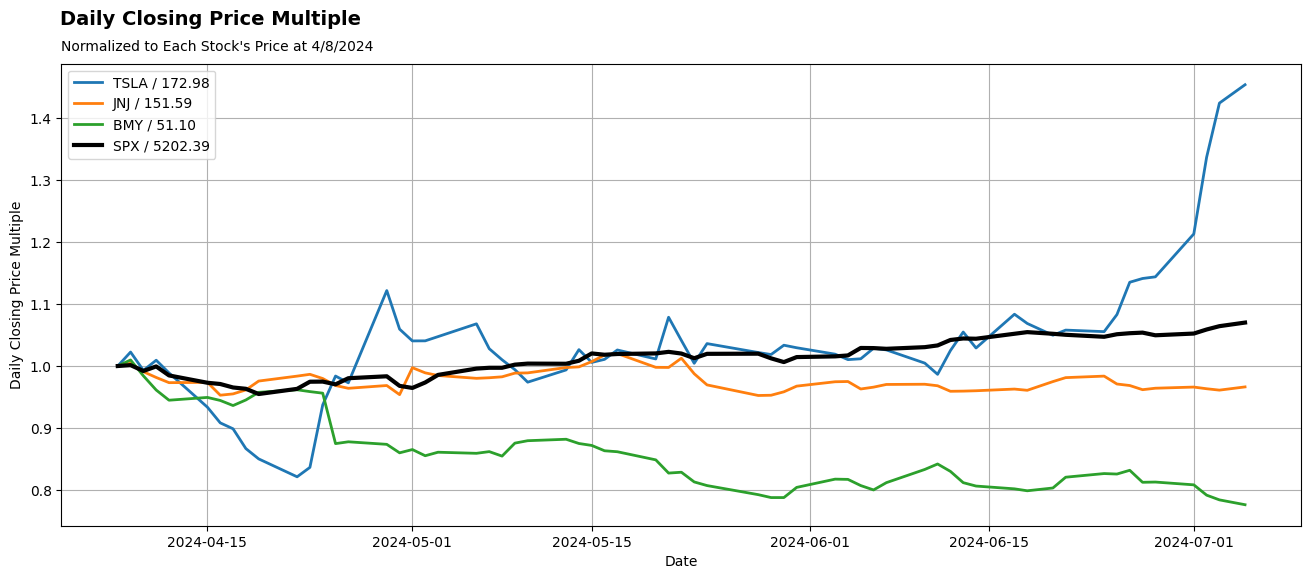

In [8]:
plt.figure(figsize=(16, 6))
for column in list(df.columns[:3]):
    plt.plot(df[column] / df[column][0], lw=2, label=f"{column} / {df[column][0]:.2f}")
column = "SPX"
plt.plot(
    df[column] / df[column][0],
    lw=3,
    color="black",
    label=f"{column} / {df[column][0]:.2f}",
)
plt.grid(True)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily Closing Price Multiple")
plt.title(
    "Normalized to Each Stock's Price at 4/8/2024",
    loc="left",
    fontsize=10,
    pad=10,
)
plt.suptitle(
    "Daily Closing Price Multiple",
    fontsize=14,
    fontweight="bold",
    x=0.124,
    y=0.97,
    ha="left",
)
plt.show()

Insights
- Tesla had a huge rebound starting the last few weeks of June, gaining approximately 50% from its base of $173
- The S&P 500 appreciated about 10% during the last 3 months

# Data Preparation

> The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection, data cleaning, construction of new attributes, and transformation of data for modeling tools.

For one approach, chip up the data into 5 day segments
- 5 is a hyperparameter to be searched
- Choose a random stock and starting day, and select 5 consecutive days
- Target feature is a label of
    - Buy if day 5 higher than day 4
    - Don't buy otherwise
    - Days 1-3 are training
    - Day 4 and 5 is for evaluation

In [9]:
df.reset_index(inplace=True)
df

,Date,TSLA,JNJ,BMY,LDOS,DOV,CVX,KKR,DGX,STZ,BX,HBAN,A,FDX,MMC,CPB,PM,PWR,XYL,AWK,MGM,RCL,WY,WMB,HAL,HAS,BRO,UNH,VTRS,RVTY,CRL,NTAP,LOW,GL,VICI,EOG,ABT,NDAQ,K,BKNG,IT,BBY,NCLH,CBRE,WFC,EXC,AMGN,MMM,ABNB,MCD,AMZN,SPX
0,2024-04-08,172.98,151.59,51.10,129.24,176.08,161.27,101.65,130.04,266.00,129.32,14.01,144.46,275.57,204.28,43.72,90.32,262.26,127.75,120.02,46.30,138.29,34.42,38.95,40.96,57.59,85.51,456.00,11.75,106.41,254.92,105.82,242.59,107.85,29.63,135.45,110.52,62.14,57.48,3601.17,471.87,80.14,19.39,96.51,57.79,37.78,269.20,91.93,160.27,267.56,185.19,5202.39
1,2024-04-09,176.88,152.29,51.60,127.10,177.35,162.00,100.27,132.75,262.97,132.00,14.04,147.40,276.37,204.33,44.45,91.07,256.40,128.93,121.85,46.41,133.18,35.03,39.24,40.98,57.33,84.56,459.72,11.82,110.72,257.15,104.15,244.39,107.61,29.80,137.06,112.44,63.56,57.12,3581.48,469.89,82.55,19.41,96.20,57.58,37.87,270.36,92.61,162.66,269.44,185.67,5209.91
2,2024-04-10,171.76,150.20,50.29,126.22,173.83,162.67,99.01,131.62,264.92,126.08,13.58,144.16,270.30,201.18,43.68,89.72,254.30,128.19,118.31,44.68,130.90,33.60,38.88,41.11,56.78,83.60,450.05,11.71,107.90,247.49,102.60,237.16,104.93,28.11,137.95,111.17,63.01,57.01,3586.13,463.78,79.89,18.40,91.33,56.94,36.91,266.45,92.63,160.28,268.67,185.95,5160.64
3,2024-04-11,174.60,148.79,49.12,126.64,173.28,161.89,100.45,130.02,268.34,126.87,13.49,145.00,272.18,199.19,43.21,89.43,258.00,128.79,117.82,44.72,133.75,33.65,38.60,40.94,56.23,82.65,441.72,11.57,108.50,246.42,104.86,235.44,49.17,28.20,137.27,111.45,63.06,56.17,3637.87,474.72,80.01,18.63,90.68,56.69,36.80,270.00,93.18,165.42,268.62,189.05,5199.06
4,2024-04-12,171.05,147.52,48.28,125.73,172.06,158.96,97.29,128.53,262.24,123.47,13.31,140.73,267.80,198.07,42.31,88.85,254.69,128.11,116.57,42.48,127.67,33.24,38.08,39.67,55.80,81.90,439.20,11.33,103.49,241.34,101.81,232.05,59.09,27.94,135.29,109.11,61.52,55.42,3531.80,465.45,78.00,17.77,89.39,56.47,36.48,267.28,91.31,159.37,267.39,186.13,5123.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2024-06-28,197.88,146.16,41.53,145.88,180.45,156.42,105.24,136.88,257.28,123.80,13.18,129.63,299.84,210.72,45.19,101.33,254.09,135.63,129.16,44.44,159.43,28.39,42.50,33.78,58.50,89.41,509.26,10.63,104.86,206.58,128.80,220.46,82.28,28.64,125.87,103.91,60.26,57.68,3961.50,449.06,84.29,18.79,89.11,59.39,34.61,312.45,102.19,151.63,254.84,193.25,5460.48
58,2024-07-01,209.86,146.44,41.30,145.56,176.99,156.52,104.51,137.09,256.29,122.23,13.16,127.40,298.68,210.25,45.27,101.25,247.61,131.53,127.76,42.86,156.47,27.56,42.39,33.43,57.52,89.11,494.65,10.59,103.00,203.24,130.24,213.56,82.83,27.90,126.54,103.20,59.48,56.72,3884.88,441.32,82.29,17.68,85.97,60.59,34.55,311.01,100.61,151.63,249.99,197.20,5475.09
59,2024-07-02,231.26,146.03,40.45,145.86,176.96,156.75,105.93,136.64,258.94,123.21,13.21,125.78,298.22,211.99,45.53,101.64,247.78,132.27,128.46,42.33,156.61,27.48,42.30,33.62,57.06,89.65,498.24,10.43,102.01,201.48,129.88,213.70,83.08,27.77,126.65,103.20,59.96,56.70,3916.21,446.12,82.17,17.61,87.08,60.97,34.53,310.77,101.62,154.34,247.79,200.00,5509.01
60,2024-07-03,246.39,145.69,40.06,146.64,176.97,156.71,106.06,140.90,250.37,123.40,13.04,126.13,293.71,212.90,45.01,101.42,254.60,132.71,127.96,43.28,155.38,27.05,42.80,33.78,57.03,90.04,489.89,10.38,102.56,201.42,130.26,213.30,82.44,27.75,126.77,102.33,60.14,56.67,3916.89,447.75,82.33,17.54,87.39,60.66,34.73,309.38,101.62,152.73,250.00,197.59,5537.02


Form the chips

In [10]:
X = df.drop(columns=["Date", "SPX"])
num_chips = 500
num_days_per_chip = 7
chips_df = pd.DataFrame()
np.random.seed(13)

while len(chips_df) < num_chips:
    random_start = X.sample(n=1, axis=1).sample(n=1, axis=0)
    stock = random_start.columns[0]
    chip = X.loc[
        random_start.index[0] : random_start.index[0] + num_days_per_chip - 1, stock
    ]
    if len(chip) == num_days_per_chip:
        start_date = df["Date"][random_start.index[0]]
        df_chip = pd.DataFrame(
            [[stock, start_date, *chip]],
            columns=["Stock", "Start Date"]
            + ["Day " + str(day + 1) for day in range(num_days_per_chip)],
        )
        chips_df = pd.concat([chips_df, df_chip], ignore_index=True).drop_duplicates()
display(chips_df)

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
0,WFC,2024-06-24,59.01,57.20,57.01,57.42,59.39,60.59,60.97
1,NTAP,2024-05-30,116.50,120.43,118.96,119.00,122.26,121.47,120.98
2,NTAP,2024-05-22,114.11,114.04,115.67,118.01,117.50,116.50,120.43
3,PWR,2024-05-21,272.05,271.10,276.55,283.43,279.64,277.97,279.76
4,MMC,2024-05-16,209.14,209.97,209.16,209.93,210.82,207.99,207.89
...,...,...,...,...,...,...,...,...,...
495,PM,2024-05-06,97.45,97.53,98.25,99.46,99.66,99.29,99.84
496,K,2024-05-01,56.98,61.28,60.51,60.04,61.64,62.33,61.60
497,HAS,2024-06-03,58.67,57.49,58.57,58.39,58.45,58.48,58.39
498,DOV,2024-06-10,177.95,177.27,181.75,181.39,177.25,179.23,182.79


In [11]:
day_buy = "Day " + str(num_days_per_chip - 1)
day_sell = "Day " + str(num_days_per_chip)
[
    day_buy,
    day_sell,
]

['Day 6', 'Day 7']

In [12]:
np.random.seed(42)
net_pl = 0.0
for _ in range(100):
    chips_df_frac = chips_df.sample(frac=0.1)
    net_pl += (chips_df_frac[day_sell] - chips_df_frac[day_buy]).sum()
net_pl

224.5099999999964

In [13]:
(chips_df[day_sell] / chips_df[day_buy]).describe()

count    500.000000
mean       1.001110
std        0.017902
min        0.925140
25%        0.992027
50%        1.000000
75%        1.008044
max        1.153069
dtype: float64

Form the target feature - day N is better than day N - 1

In [14]:
chips_df["Buy"] = chips_df[day_sell] > 1.01 * chips_df[day_buy]
chips_df

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Buy
0,WFC,2024-06-24,59.01,57.20,57.01,57.42,59.39,60.59,60.97,False
1,NTAP,2024-05-30,116.50,120.43,118.96,119.00,122.26,121.47,120.98,False
2,NTAP,2024-05-22,114.11,114.04,115.67,118.01,117.50,116.50,120.43,True
3,PWR,2024-05-21,272.05,271.10,276.55,283.43,279.64,277.97,279.76,False
4,MMC,2024-05-16,209.14,209.97,209.16,209.93,210.82,207.99,207.89,False
...,...,...,...,...,...,...,...,...,...,...
495,PM,2024-05-06,97.45,97.53,98.25,99.46,99.66,99.29,99.84,False
496,K,2024-05-01,56.98,61.28,60.51,60.04,61.64,62.33,61.60,False
497,HAS,2024-06-03,58.67,57.49,58.57,58.39,58.45,58.48,58.39,False
498,DOV,2024-06-10,177.95,177.27,181.75,181.39,177.25,179.23,182.79,True


In [15]:
chips_df["Buy"].value_counts(normalize=True)

Buy
False    0.784
True     0.216
Name: proportion, dtype: float64

# Modeling

> In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques require specific data formats.

Techniques to consider so far
- Time-series regression, such as with sarimax
- Classification
    - Decision Tree
    - Random Forest
    - SVM
    - NN

## Decision Tree

### Approach

Fit a classifier, using days 1 through N - 2 as features and the "Buy" column as the target
- So you buy on day N - 1, and sell on day N
- The criterion then is that the day you sell is higher than the day you buy

### Features

In [16]:
features = ["Day " + str(k) for k in range(1, num_days_per_chip - 1)]
X, y = chips_df[features], chips_df["Buy"]
X = StandardScaler().fit_transform(X)
features

['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']

In [17]:
risk = 100.0  # dollars invested per trade
pl = (chips_df[day_sell] / chips_df[day_buy] - 1.0) * risk

In [18]:
pl.describe()

count    500.000000
mean       0.111025
std        1.790210
min       -7.486034
25%       -0.797327
50%        0.000000
75%        0.804397
max       15.306911
dtype: float64

### Model

In [19]:
(X_train, X_test, y_train, y_test, pl_train, pl_test) = train_test_split(
    X, y, pl, random_state=42, stratify=y
)

In [20]:
dtc = DecisionTreeClassifier(
    random_state=42,
).fit(X_train, y_train)
[
    dtc.score(X_train, y_train),
    dtc.score(X_test, y_test),
]

[1.0, 0.768]

In [46]:
def ConfusionMatrixPlot(estimator, X, y) -> None:
    ConfusionMatrixDisplay(
        confusion_matrix(y, estimator.predict(X)),
        display_labels=["Don't Buy", "Buy"],
    ).plot()
    plt.grid(False)

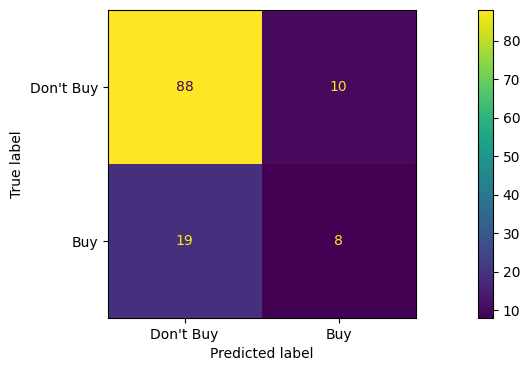

In [51]:
ConfusionMatrixPlot(dtc, X_test, y_test)

In [21]:
def calculate_trading_gain(estimator, X, pl):
    y_pred = estimator.predict(X)
    total_gain = round(float(pl[y_pred].sum()), 2)
    return {
        "total gain": total_gain,
        "number of trades": len(X),
    }

In [22]:
calculate_trading_gain(dtc, X_test, pl_test)

{'total gain': 7.31, 'number of trades': 125}

### Assessment

The initial model is a poor performer
- Although the training accuracy was 100%, the test accuracy was only 77%
- Worse, the cumulative profit considering 125 trades was only $8

## Random Forest

### Approach

Same as decision tree
- But use a random forest for ensemble development
- Use grid search to optimize the forest

### Model

In [23]:
rfc = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=42).fit(
    X_train, y_train
)
[
    rfc.score(X_train, y_train),
    rfc.score(X_test, y_test),
    rfc.oob_score_,
]

[0.9973333333333333, 0.752, 0.7306666666666667]

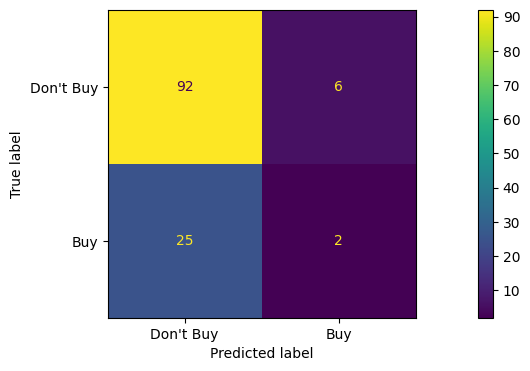

In [52]:
ConfusionMatrixPlot(rfc, X_test, y_test)

In [24]:
calculate_trading_gain(rfc, X_test, pl_test)

{'total gain': 0.11, 'number of trades': 125}

### Model with Grid Search

In [56]:
param_grid = {
    "n_estimators": [1, 10, 50, 100],
    "max_features": [3, 5],
    "criterion": ["gini", "log_loss"],
}

In [78]:
grid = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    scoring="neg_log_loss",
).fit(X_train, y_train)

In [79]:
[
    grid.score(X_train, y_train),
    grid.score(X_test, y_test),
]

[-0.14705364131954018, -1.3404568123929146]

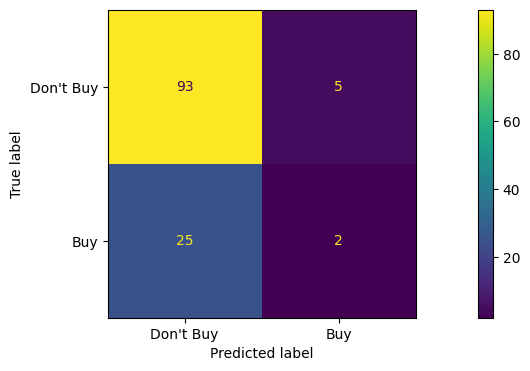

In [80]:
ConfusionMatrixPlot(grid.best_estimator_, X_test, y_test)

In [81]:
grid.best_params_

{'criterion': 'log_loss', 'max_features': 5, 'n_estimators': 100}

In [82]:
calculate_trading_gain(grid.best_estimator_, X_test, pl_test)

{'total gain': -0.26, 'number of trades': 125}

# Evaluation

> At this stage in the project you have built one or more models that appear to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.

# Deployment

> Creation of the model is generally not the end of the project. Usually, the knowledge gained will need to be organized and presented in a way that the customer can use it. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining process. In many cases it will be the user, not the data analyst, who will carry out the deployment steps. In any case, it is important to understand up front what actions will need to be carried out in order to actually make use of the created models.